# ML MP2 - Einar López Altamirano

# **Note:** Running this notebook takes over an hour. To speed up the process, you can exclude SVM and the learning curves for both SVM and Random Forest. Simply set the variable **include_svm** to **False**. If you want to see the results with SVM and the Random Forest learning curve, they are available in the notebook.

In [124]:
include_svm = True

## 1. Install required libraries & imports

In [125]:
! pip install pandas fsspec huggingface_hub nltk


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [126]:
from sklearn.model_selection import train_test_split
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import LearningCurveDisplay, learning_curve
import seaborn as sns

## 2. Download NLTK stopwords

In [127]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/einar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 3. Download dataset from HuggingFace

In [128]:
df_reviews = pd.read_csv("hf://datasets/Q-b1t/IMDB-Dataset-of-50K-Movie-Reviews-Backup/archive.zip")
print("df shape: ", df_reviews.shape)

df shape:  (50000, 2)


## 4. Dataset Analysis

In [129]:
# Count NaN values
print(df_reviews.isna().sum())

review       0
sentiment    0
dtype: int64


In [130]:
# Count empty reviews
print((df_reviews["review"].eq("").sum()))

0


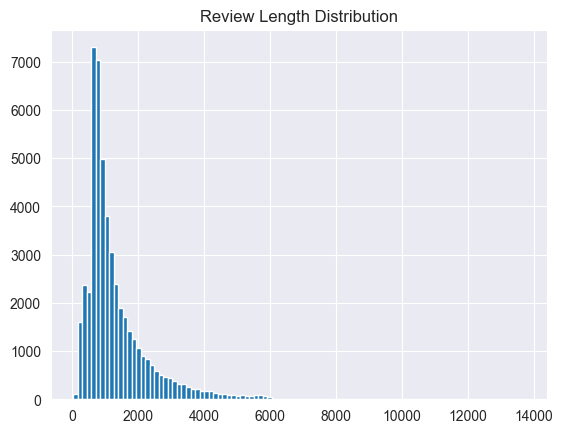

In [131]:
plt.title("Review Length Distribution")
df_reviews["review"].str.len().hist(bins=100)
plt.show()

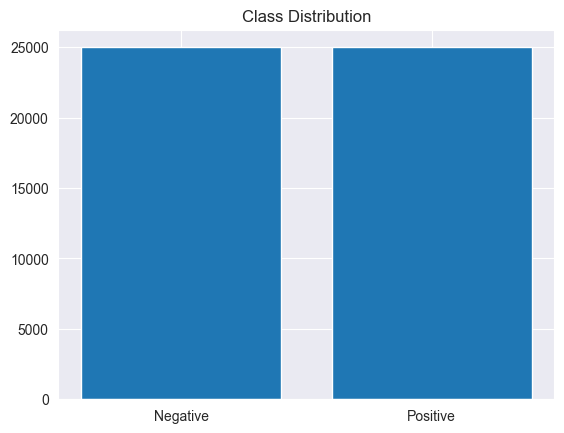

In [132]:
plt.title("Class Distribution")
plt.bar(["Negative", "Positive"] ,df_reviews["sentiment"].value_counts())
plt.show()

## 5. Classes & Data Splitting

In [133]:
df_reviews["sentiment"] = df_reviews["sentiment"].map({"positive": 1, "negative": 0})

In [134]:
X_train, X_test, y_train, y_test = train_test_split(df_reviews["review"], df_reviews["sentiment"], test_size=0.5, random_state=42)

## 6. Data Preprocessing

In [135]:
# Transform to lowercase
X_train = X_train.str.lower()
X_test = X_test.str.lower()

In [136]:
# Remove special characters
X_train = X_train.str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)
X_test = X_test.str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)

In [137]:
# Remove stopwords and tokenize
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def tokenize(text):
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

X_test= X_test.apply(tokenize)
X_train= X_train.apply(tokenize)


In [138]:
# Vectorize
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train)
X_test= vectorizer.transform(X_test)

## 7. Modeling

In [139]:
if include_svm:
  svm_model = SVC(kernel="rbf", C=1, gamma=0.1)
  svm_model.fit(X_train, y_train)
  y_pred_svm = svm_model.predict(X_test)

In [140]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

In [141]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

## 8. Evaluation

In [142]:
def plot_metrics(y_test, y_preds, model_names):

    metrics = {
        "Accuracy": [],
        "F1 Score": [],
        "Recall": [],
        "Precision": []
    }

    # Compute metrics for each model
    for y_pred in y_preds:
        metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
        metrics["F1 Score"].append(f1_score(y_test, y_pred))
        metrics["Recall"].append(recall_score(y_test, y_pred))
        metrics["Precision"].append(precision_score(y_test, y_pred))

    x_labels = list(metrics.keys())
    scores = np.array(list(metrics.values()))

    # Plot bar charts
    plt.figure(figsize=(10, 6))
    bar_width = 0.2
    x = np.arange(len(x_labels))

    # Generate bars for each model
    for i, model_name in enumerate(model_names):
        plt.bar(x + i * bar_width, scores[:, i], width=bar_width, label=model_name)
        print(f"{model_name}:")
        for j, metric in enumerate(x_labels):
            print(f"{metric}: {scores[j, i]:.3f}")
        print("\n")


    plt.xticks(x + (len(model_names) - 1) * bar_width / 2, x_labels)
    plt.ylabel("Score")
    plt.title("Model Performance Metrics")
    plt.legend()
    plt.ylim(0, 1)
    plt.show()


In [143]:
def plot_learning_curves(models, model_names, X_train, y_train, cv=5):
    fig, axes = plt.subplots(len(models), 1, figsize=(6, 12))

    # When include_svm is False
    if len(models) == 1:
       axes = [axes]

    # Generate learning curves for each model
    for ax, model, name in zip(axes, models, model_names):
        train_sizes, train_scores, test_scores = learning_curve(
            model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
        )
        display = LearningCurveDisplay(
            train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Accuracy"
        )
        display.plot(ax=ax)
        ax.set_title(name)

    plt.tight_layout()
    plt.show()


In [144]:
def plot_confusion_matrices(y_preds, model_names, y_test, class_labels):

    fig, axes = plt.subplots(len(y_preds), 1, figsize=(6, 12))

    # Generate confusion matrix for each model
    for ax, y_pred, name in zip(axes, y_preds, model_names):
        cm = confusion_matrix(y_test, y_pred)

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=ax)
        ax.set_title(f"Confusion Matrix - {name}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    plt.tight_layout()
    plt.show()


SVM:
Accuracy: 0.881
F1 Score: 0.884
Recall: 0.903
Precision: 0.865


Naive Bayes:
Accuracy: 0.850
F1 Score: 0.851
Recall: 0.857
Precision: 0.846


Random Forest:
Accuracy: 0.845
F1 Score: 0.844
Recall: 0.837
Precision: 0.852




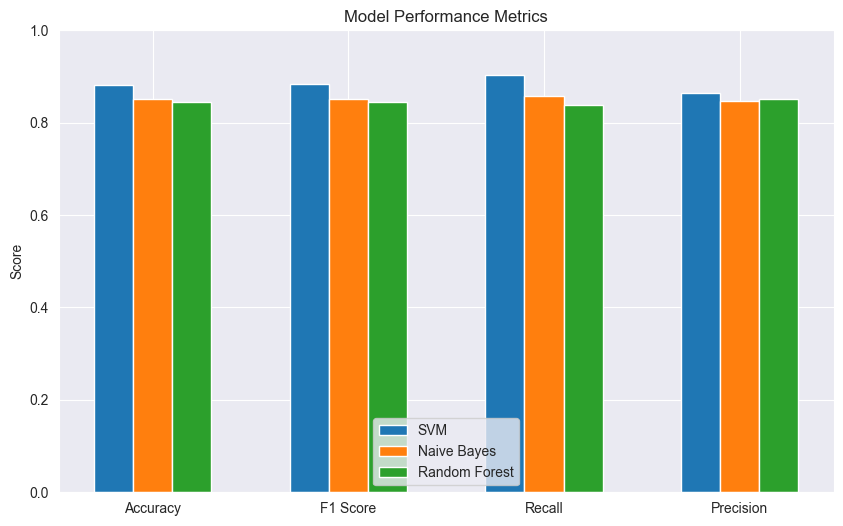

In [145]:
if include_svm:
  plot_metrics(y_test, [y_pred_svm, y_pred_nb, y_pred_rf], ["SVM", "Naive Bayes", "Random Forest"])
else:
  plot_metrics(y_test, [y_pred_nb, y_pred_rf], ["Naive Bayes", "Random Forest"])

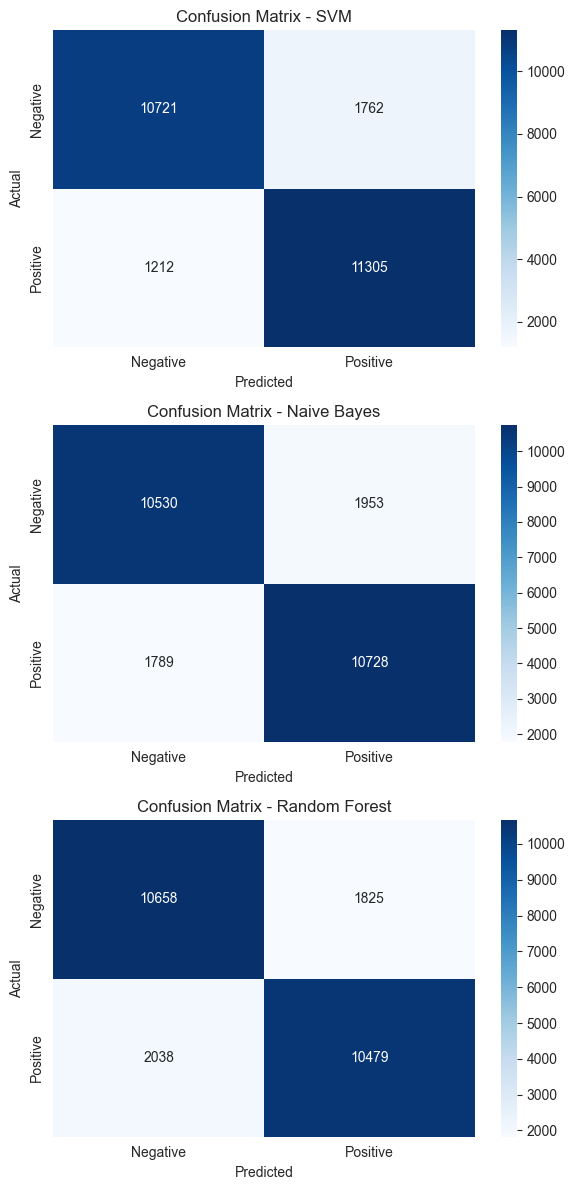

In [146]:
if include_svm:
  plot_confusion_matrices([y_pred_svm, y_pred_nb, y_pred_rf], ["SVM", "Naive Bayes", "Random Forest"], y_test, ["Negative", "Positive"])
else:
  plot_confusion_matrices([y_pred_nb, y_pred_rf], ["Naive Bayes", "Random Forest"], y_test, ["Negative", "Positive"])

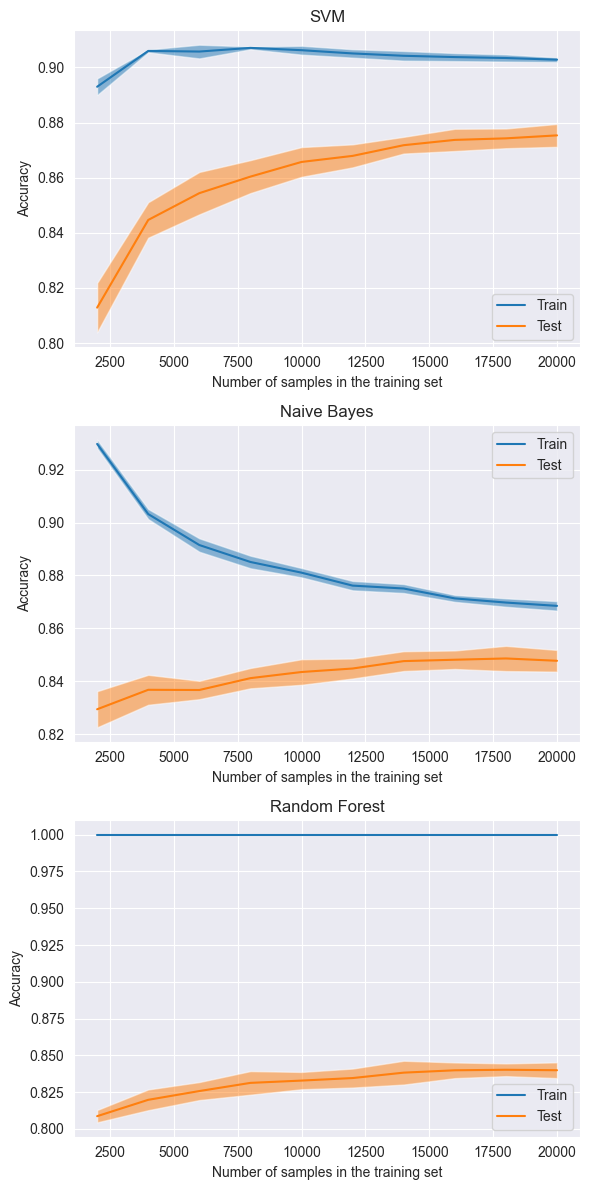

In [147]:
if include_svm:
  plot_learning_curves([svm_model, nb_model, rf_model], ["SVM", "Naive Bayes", "Random Forest"], X_train, y_train)
else:
  plot_learning_curves([nb_model], ["Naive Bayes"], X_train, y_train)